In [1]:
# pip install 'pyLDAvis'


In [2]:
# pip install pyLDAvis==3.2.2

In [3]:
import pandas as pd
import os
import time
import math
import re
from pprint import pprint
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()
import warnings
warnings.simplefilter('ignore')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
num_processors = multiprocessing.cpu_count()
num_processors


4

In [5]:

workers = num_processors-1

print(f'Using {workers} workers')

Using 3 workers


In [70]:
df = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 
df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing - Wheaton Roof I...,About Greater Chicago Roofing - Wheaton Roof I...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing - Naperv...,Some Ideas on Greater Chicago Roofing - Naperv...
2,2022-05-29,english,Greater Chicago Roofing - Wheaton Skylight Rep...,All about Greater Chicago Roofing - Wheaton Gu...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois - Fourteen people were injure..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing - Wh...,What Does Greater Chicago Roofing - Wheaton Gu...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago - Opera ...,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. (AP) — Marcus Domask had a se..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The #...","A Good Reason To Visit Illinois, Stay At The #..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [71]:
# Remove special characters to avoid problems with analysis
df['title'] = df['title'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df['text']= df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof In...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervi...
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gut...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois Fourteen people were injured..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gut...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago Opera News,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. AP Marcus Domask had a seaso..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The 1...","A Good Reason To Visit Illinois, Stay At The 1..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [73]:
#Taking out duplicate articles with title and text 
df=df.drop_duplicates(subset= ['title','text'], keep= 'first')
#Taking out articles with the same title


In [76]:
df=df.drop_duplicates(subset= ['title'], keep= 'first')
df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof In...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervi...
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gut...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois Fourteen people were injured..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gut...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago Opera News,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. AP Marcus Domask had a seaso..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The 1...","A Good Reason To Visit Illinois, Stay At The 1..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [77]:
df=df.drop_duplicates(subset= ['text'], keep= 'first')
df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof In...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervi...
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gut...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois Fourteen people were injured..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gut...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago Opera News,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. AP Marcus Domask had a seaso..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The 1...","A Good Reason To Visit Illinois, Stay At The 1..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [ ]:
# #Taking out articles written before May 1st because I want to focus on the warmer months, just to see if weather is still a factor
# df['date'] = pd.to_datetime(df['date'])

# df = df[~(df['date'] < '2022-05-01')]
# df

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import gensim, spacy, logging, warnings
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'chicago', 'illinois'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 3min 41s, sys: 3.31 s, total: 3min 44s
Wall time: 3min 44s


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
#!python3 -m spacy download en 

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



In [ ]:
data_ready = process_words(data_tokens)  # processed Text Data

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
%%time

lda_model = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics=25,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers= workers, 
                   per_word_topics=True)

CPU times: user 21min 12s, sys: 2min 30s, total: 23min 43s
Wall time: 34min 52s


In [ ]:
pprint(lda_model.print_topics())

[(20,
  '0.008*"lawyer" + 0.007*"loan" + 0.006*"insurance" + 0.006*"help" + '
  '0.006*"time" + 0.005*"work" + 0.004*"company" + 0.004*"business" + '
  '0.004*"accident" + 0.004*"find"'),
 (17,
  '0.018*"city" + 0.014*"community" + 0.013*"new" + 0.010*"year" + '
  '0.008*"project" + 0.008*"company" + 0.007*"area" + 0.006*"building" + '
  '0.006*"move" + 0.006*"plan"'),
 (1,
  '0.014*"state" + 0.011*"vote" + 0.010*"election" + 0.009*"former" + '
  '0.008*"candidate" + 0.007*"campaign" + 0.007*"primary" + 0.007*"trump" + '
  '0.007*"year" + 0.006*"political"'),
 (7,
  '0.033*"bear" + 0.018*"season" + 0.016*"team" + 0.014*"year" + 0.014*"coach" '
  '+ 0.012*"player" + 0.010*"play" + 0.009*"draft" + 0.008*"new" + '
  '0.007*"game"'),
 (13,
  '0.037*"police" + 0.016*"officer" + 0.016*"shoot" + 0.013*"man" + '
  '0.012*"people" + 0.009*"kill" + 0.009*"charge" + 0.008*"report" + '
  '0.008*"fire" + 0.007*"gun"'),
 (23,
  '0.036*"school" + 0.028*"covid" + 0.017*"district" + 0.014*"student" + '

In [ ]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5435460456334056
CPU times: user 24.5 s, sys: 4.03 s, total: 28.6 s
Wall time: 10min 51s


In [ ]:
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.613633442630773


In [ ]:
pip install pyLDAvis==3.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis.gensim 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.161367  0.011548       1        1  6.669845
20     0.116440 -0.011520       2        1  6.197354
12    -0.098610 -0.055449       3        1  5.986668
6     -0.081249 -0.062705       4        1  5.790542
7     -0.121934 -0.099677       5        1  5.268329
10    -0.199026 -0.097731       6        1  5.190575
2     -0.012477  0.103193       7        1  4.771438
21     0.102483  0.109273       8        1  4.526936
22     0.105931  0.142220       9        1  4.290783
4      0.218368 -0.119694      10        1  4.252962
23    -0.074764  0.051582      11        1  4.229272
8     -0.160211 -0.116561      12        1  4.147727
17    -0.022060  0.091197      13        1  3.884900
0      0.057694  0.183137      14        1  3.882552
24     0.140506 -0.054255      15        1  3.579593
14    -0.170259 -0.131012      16        1  3.557772
16    -0.003371  0.282495      17        1  3.466164
1     -0.126179  0.027009      18        1  3.334549
19    -0.100888 -0.001290      19        1  2.955445
18     0.025615  0.011436      20        1  2.685107
5      0.206275 -0.138324      21        1  2.649835
15     0.158115 -0.060941      22        1  2.647772
3     -0.056842  0.137329      23        1  2.450975
9      0.112918 -0.100583      24        1  1.831625
11     0.144892 -0.100677      25        1  1.751280, topic_info=         Term           Freq          Total Category  logprob  loglift
214      roof  198794.000000  198794.000000  Default  30.0000  30.0000
216   roofing  133076.000000  133076.000000  Default  29.0000  29.0000
2610     game  130351.000000  130351.000000  Default  28.0000  28.0000
654    police   88253.000000   88253.000000  Default  27.0000  27.0000
1678    share  100999.000000  100999.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
149      much    3006.003172   56489.114579  Topic25  -5.3250   1.1114
2008      man    2885.303959   47930.054953  Topic25  -5.3660   1.2347
281      area    2687.888607   63249.043462  Topic25  -5.4368   0.8865
479      call    2415.399992   66487.477515  Topic25  -5.5437   0.7297
920      site    2317.119281   29085.169073  Topic25  -5.5853   1.5149

[2148 rows x 6 columns], token_table=        Topic      Freq           Term
term                                  
347706     18  0.999896  aa_faeb__aa_d
6946        7  0.013588            aaa
6946       16  0.087569            aaa
6946       19  0.886259            aaa
6946       23  0.010569            aaa
...       ...       ...            ...
11269       6  0.999827    zach_lavine
9868        3  0.999732      zelenskyy
10287      23  0.999056  zennie_create
13386      13  0.993870   zeroemission
28787      25  0.999604      zoyganele

[13003 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 21, 13, 7, 8, 11, 3, 22, 23, 5, 24, 9, 18, 1, 25, 15, 17, 2, 20, 19, 6, 16, 4, 10, 12])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=25, step=3)

In [ ]:
print(model_list)

[<gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fda076ab490>]


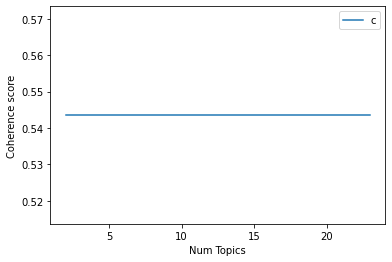

In [ ]:
# Show graph
limit=25; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Select the model and print the topics

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(9,
  '0.014*"dental" + 0.011*"well" + 0.010*"treatment" + 0.009*"race" + '
  '0.009*"health" + 0.008*"tooth" + 0.008*"patient" + 0.007*"actually" + '
  '0.006*"care" + 0.006*"medical"'),
 (5,
  '0.077*"roof" + 0.049*"roofing" + 0.022*"cover" + 0.021*"system" + '
  '0.018*"great" + 0.016*"well" + 0.009*"certainly" + 0.009*"shingle" + '
  '0.008*"new" + 0.007*"require"'),
 (18,
  '0.033*"school" + 0.027*"student" + 0.016*"program" + 0.013*"college" + '
  '0.011*"education" + 0.011*"care" + 0.010*"high" + 0.010*"university" + '
  '0.009*"pizza" + 0.008*"year"'),
 (10,
  '0.044*"game" + 0.032*"point" + 0.023*"bull" + 0.018*"team" + 0.014*"season" '
  '+ 0.013*"last" + 0.012*"play" + 0.011*"first" + 0.011*"win" + '
  '0.010*"score"'),
 (16,
  '0.062*"share" + 0.043*"stock" + 0.040*"quarter" + 0.033*"company" + '
  '0.031*"tool_work" + 0.026*"rating" + 0.019*"report" + 0.018*"price" + '
  '0.016*"last" + 0.015*"buy"'),
 (17,
  '0.018*"city" + 0.014*"community" + 0.013*"new" + 0.010*"year" 

In [ ]:
# def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df):
   
#     sent_topics_df = pd.DataFrame()

   
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each article
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # -- dominant topic
#                 p = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in p])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Adding original text in the end
    
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)

# df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df)


# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


# df_dominant_topic.head(5)

Sentiment Analysis

In [9]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# df = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 
# df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing - Wheaton Roof I...,About Greater Chicago Roofing - Wheaton Roof I...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing - Naperv...,Some Ideas on Greater Chicago Roofing - Naperv...
2,2022-05-29,english,Greater Chicago Roofing - Wheaton Skylight Rep...,All about Greater Chicago Roofing - Wheaton Gu...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois - Fourteen people were injure..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing - Wh...,What Does Greater Chicago Roofing - Wheaton Gu...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago - Opera ...,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. (AP) — Marcus Domask had a se..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The #...","A Good Reason To Visit Illinois, Stay At The #..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [78]:
df

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof In...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervi...
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gut...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,"SENECA, Illinois Fourteen people were injured..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gut...
...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago Opera News,Jordan Kyrou and Pavel Buchnevich are expected...
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,"CARBONDALE, Ill. AP Marcus Domask had a seaso..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The 1...","A Good Reason To Visit Illinois, Stay At The 1..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...


In [ ]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()

# sentiment_vader = pd.DataFrame()
# sentiment_vader['vader'] = df['text'].apply(analyzer.polarity_scores)
# sentiment_vader = pd.DataFrame(sentiment_vader['vader'].tolist())

# # Create a positive / negative sentiment variable
# sentiment_vader['sentiment'] = np.where(sentiment_vader['compound'].astype(np.float) > 0, 'Positive', 'Negative')
# sentiment_vader['sentiment'] = np.where(sentiment_vader['compound'].astype(np.float) == 0, 'Neutral', sentiment_vader['sentiment'])

# # Merge Vader values with Sentiments
# df = pd.merge(df, sentiment_vader, left_index=True, right_index=True)
# df[['text', 'sentiment', 'compound']].head(5)

In [ ]:
# df['sentiment'].value_counts()

In [79]:
# Cleaning the text in the text column
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the text column
df['text'] = df['text'].apply(clean)
df.head()

,date,language,title,text
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof Ins...
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervil...
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gutt...
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,SENECA Illinois Fourteen people were injured w...
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gutt...


In [80]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [81]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['POS tagged'] = df['text'].apply(token_stop_pos)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,date,language,title,text,POS tagged
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof Ins...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervil...,"[(Ideas, n), (Greater, n), (Chicago, n), (Roof..."
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,SENECA Illinois Fourteen people were injured w...,"[(SENECA, n), (Illinois, n), (Fourteen, n), (p..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."


In [82]:
type(df['POS tagged'][0])

list

In [83]:
df2 = df.copy()
df2

,date,language,title,text,POS tagged
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof Ins...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervil...,"[(Ideas, n), (Greater, n), (Chicago, n), (Roof..."
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,SENECA Illinois Fourteen people were injured w...,"[(SENECA, n), (Illinois, n), (Fourteen, n), (p..."
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh..."
...,...,...,...,...,...
199937,2022-02-12,english,Projected Lineup: Feb. 12 vs. Chicago Opera News,Jordan Kyrou and Pavel Buchnevich are expected...,"[(Jordan, n), (Kyrou, n), (Pavel, n), (Buchnev..."
199938,2022-02-16,english,Domask scores 25 to lead S. Illinois over Brad...,CARBONDALE Ill AP Marcus Domask had a seasonhi...,"[(CARBONDALE, n), (Ill, n), (AP, n), (Marcus, ..."
199939,2022-02-16,english,"A Good Reason To Visit Illinois, Stay At The 1...",A Good Reason To Visit Illinois Stay At The Ho...,"[(Good, a), (Reason, n), (Visit, v), (Illinois..."
199940,2022-02-17,english,Prosecutors agree to drop another 19 cases tie...,Cook County prosecutors agreed Wednesday to dr...,"[(Cook, n), (County, n), (prosecutors, n), (ag..."


In [84]:
def removeNone(pos_list):
  new_list = [item for item in pos_list if not None in item]
  return new_list

In [85]:
df['POS tagged'] = df['POS tagged'].apply(removeNone)

Obtaining Stem Words - Lemmatization 

In [86]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_ = " "
    for word, pos in pos_data:
      if not pos:
        lemma = word
        lemma_ = lemma_ + " " + lemma
      else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_ + " " + lemma
    return lemma_




In [87]:
df['Lemma'] = df['POS tagged'].apply(lemmatize)
df.sample(30)

,date,language,title,text,POS tagged,Lemma
103341,2022-05-25,english,Chicago Med Steven Weber Speaks on Deans Relat...,Chicago Med has seen a lot of personal growth ...,"[(Chicago, n), (Med, n), (seen, v), (lot, n), ...",Chicago Med see lot personal growth doctor E...
190245,2022-06-15,english,"Naked Woman Drove Off in Chicago PD Vehicle, R...",A naked woman stole a Chicago police squad car...,"[(naked, a), (woman, n), (stole, v), (Chicago,...",naked woman steal Chicago police squad car h...
166618,2022-03-02,english,EXPO CHICAGO 2022 returns to Navy Pier inperso...,Expo Chicago is back on Navy Pier in April wit...,"[(Expo, n), (Chicago, n), (back, r), (Navy, n)...",Expo Chicago back Navy Pier April art galler...
58632,2022-04-04,english,"Receptionist EYE Q OPTIQUE Chicago, IL",Office Receptionist Optical SalesAre you outgo...,"[(Office, n), (Receptionist, n), (Optical, n),...",Office Receptionist Optical SalesAre outgo f...
88253,2022-01-16,english,Digital Marketing Company Marketing Agency B...,Rataskaevu Tallinn Estonia Estonia Illinois Un...,"[(Rataskaevu, n), (Tallinn, n), (Estonia, n), ...",Rataskaevu Tallinn Estonia Estonia Illinois ...
113328,2022-03-15,english,Moving From Chicago To New York Expert Tips ...,Moving From Chicago To New York Expert Tips Ad...,"[(Moving, v), (Chicago, n), (New, n), (York, n...",Moving Chicago New York Expert Tips Advice M...
139646,2022-01-30,english,Bizimana lifts E. Illinois over Tennessee St. ...,CHARLESTON Ill Paul Bizimana had points as Eas...,"[(CHARLESTON, n), (Ill, n), (Paul, n), (Bizima...",CHARLESTON Ill Paul Bizimana point Eastern I...
19645,2022-04-08,english,Oregon claims Illinois COVID testing company s...,SALEM Ore APCBS The state of Oregon accused ow...,"[(SALEM, n), (Ore, n), (APCBS, n), (state, n),...",SALEM Ore APCBS state Oregon accuse owner Il...
150939,2022-06-24,english,Jordans King Says He Would Support a Middle Ea...,Jordans King Abdullah II said he would suppor...,"[(Jordans, n), (King, n), (Abdullah, n), (II, ...",Jordans King Abdullah II say support formati...
73871,2022-05-01,english,Wohnbebauung fr 330 W Chestnut in Chicago geplant,A zoning application for residential developme...,"[(zoning, n), (application, n), (residential, ...",zoning application residential development W...


Sentiment Analysis using Text Blob

In [88]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# function to analyze the text
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [89]:
df['Subjectivity'] = df['Lemma'].apply(getSubjectivity) 
df['Polarity'] = df['Lemma'].apply(getPolarity) 
df['Analysis'] = df['Polarity'].apply(analysis)
df.head()

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof Ins...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Roof Install...,0.436085,0.163446,Positive
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervil...,"[(Ideas, n), (Greater, n), (Chicago, n), (Roof...",Ideas Greater Chicago Roofing Naperville Sky...,0.452757,0.158412,Positive
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Gutter Repla...,0.461698,0.241563,Positive
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,SENECA Illinois Fourteen people were injured w...,"[(SENECA, n), (Illinois, n), (Fourteen, n), (p...",SENECA Illinois Fourteen people injure boat ...,0.432353,-0.082353,Negative
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Gutter Insta...,0.531250,0.364583,Positive


In [90]:
tb_counts = df.Analysis.value_counts()

tb_counts

Positive    109072
Negative     27403
Neutral      11305
Name: Analysis, dtype: int64

Vader Sentiment Analysis

In [91]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']



In [92]:
df['Vader Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

In [93]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'


In [94]:
df['Vader Analysis'] = df['Vader Sentiment'].apply(vader_analysis)
df.head()

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
0,2022-05-29,english,About Greater Chicago Roofing Wheaton Roof In...,About Greater Chicago Roofing Wheaton Roof Ins...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Roof Install...,0.436085,0.163446,Positive,0.9957,Positive
1,2022-05-29,english,Some Ideas on Greater Chicago Roofing Napervi...,Some Ideas on Greater Chicago Roofing Napervil...,"[(Ideas, n), (Greater, n), (Chicago, n), (Roof...",Ideas Greater Chicago Roofing Naperville Sky...,0.452757,0.158412,Positive,0.9981,Positive
2,2022-05-29,english,Greater Chicago Roofing Wheaton Skylight Repl...,All about Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Gutter Repla...,0.461698,0.241563,Positive,0.9991,Positive
3,2022-05-29,english,14 injured when boat explodes at marina in Sen...,SENECA Illinois Fourteen people were injured w...,"[(SENECA, n), (Illinois, n), (Fourteen, n), (p...",SENECA Illinois Fourteen people injure boat ...,0.432353,-0.082353,Negative,-0.9719,Negative
4,2022-05-29,english,The Best Guide To Greater Chicago Roofing Whe...,What Does Greater Chicago Roofing Wheaton Gutt...,"[(Greater, n), (Chicago, n), (Roofing, n), (Wh...",Greater Chicago Roofing Wheaton Gutter Insta...,0.531250,0.364583,Positive,0.8885,Positive


In [95]:
vader_counts = df['Vader Analysis'].value_counts()
vader_counts


Positive    85346
Negative    32933
Neutral     29501
Name: Vader Analysis, dtype: int64

([<matplotlib.patches.Wedge at 0x7fa95001a190>,
 [Text(-0.26525188500673036, 1.0675398997228986, 'Positive'),
  Text(-0.41169846731646703, -1.020051161466557, 'Negative'),
  Text(1.0931001172767276, -0.7922323734925283, 'Neutral')],
 [Text(-0.14468284636730747, 0.5822944907579446, '57.8%'),
  Text(-0.22456280035443654, -0.556391542618122, '22.3%'),
  Text(0.6882482219890507, -0.49881297590270296, '20.0%')])

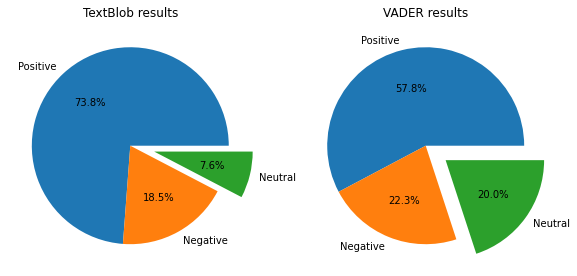

In [96]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("TextBlob results")
plt.pie(tb_counts.values, labels = tb_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.subplot(1,3,2)
plt.title("VADER results")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)


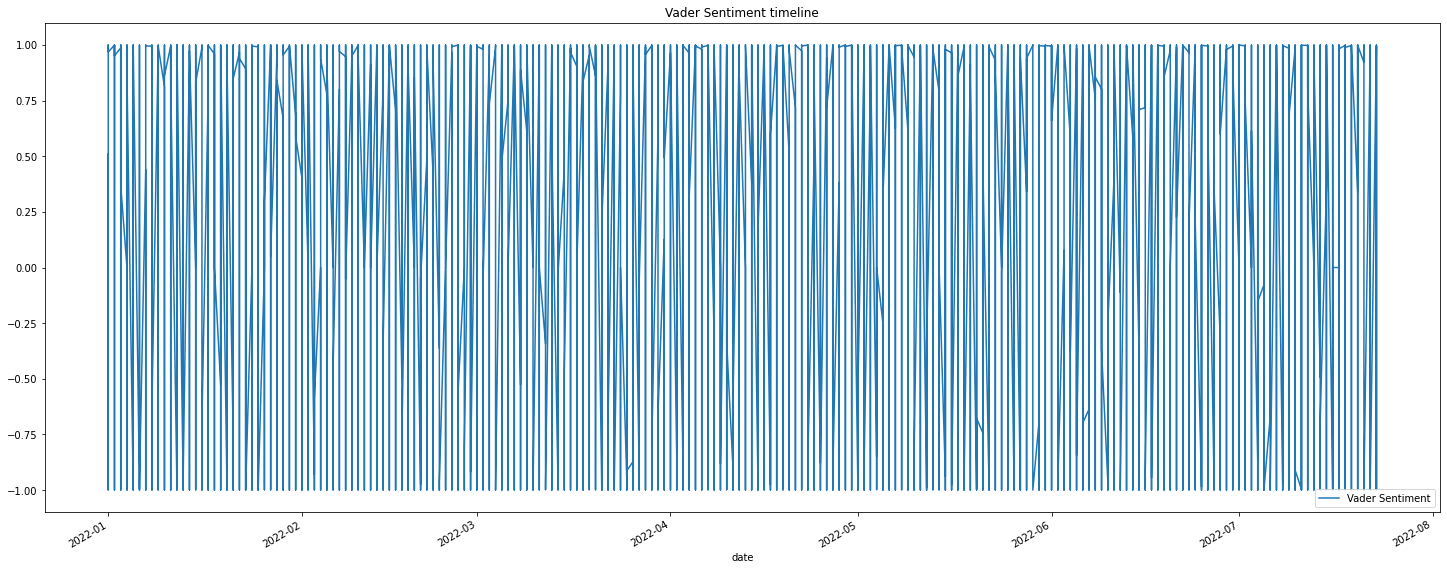

In [108]:
#Timeline Sentiment for Vader
plt.rcParams["figure.figsize"] = (25,10)

timeline_df = df[['date', 'Vader Sentiment']].set_index('date')


timeline_df.plot()
plot = plt.title(f'Vader Sentiment timeline')

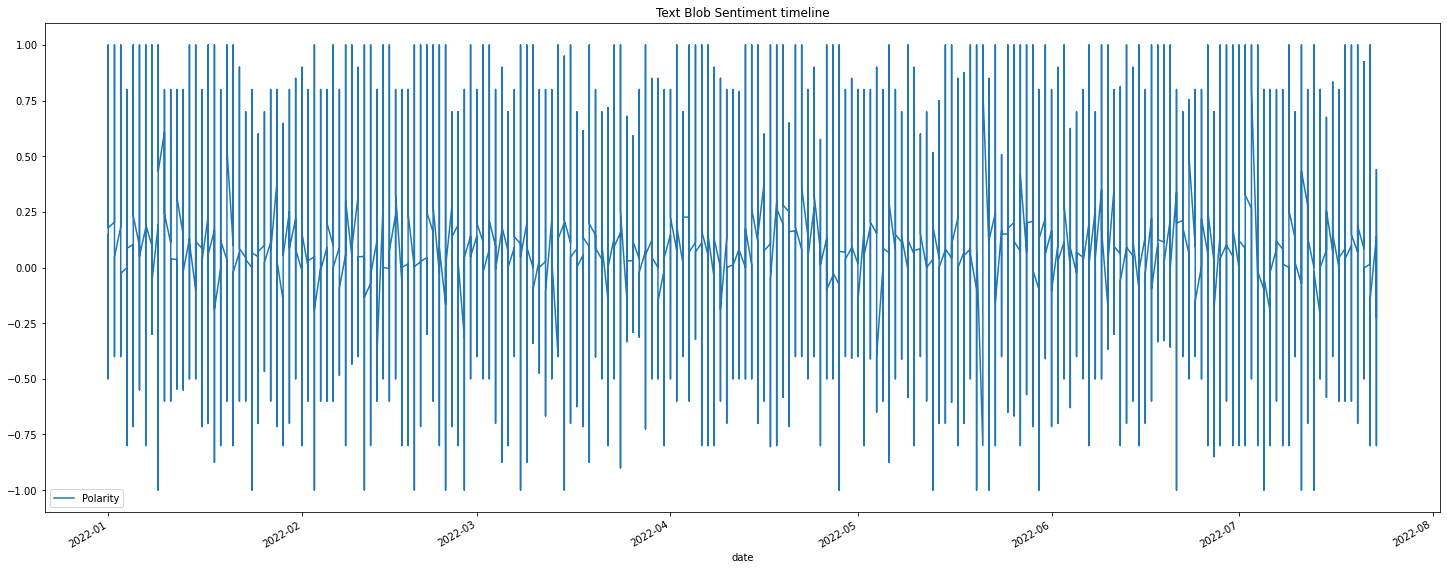

In [110]:
#Timeline Sentiment for Text Blob
plt.rcParams["figure.figsize"] = (25,10)

timeline_df2 = df[['date', 'Polarity']].set_index('date')


timeline_df2.plot()
plot = plt.title(f'Text Blob Sentiment timeline')

Positive    85346
Negative    32933
Neutral     29501
dtype: int64


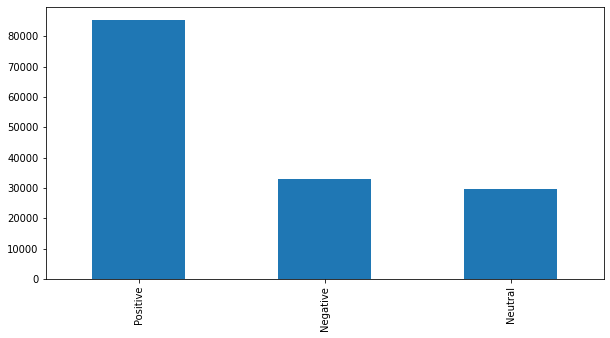

In [99]:
plt.figure().set_size_inches(10, 5)

CountSentiment = pd.value_counts(df['Vader Analysis'].values, sort=True)
print (CountSentiment)

#CountStatus.plot.barh()
CountSentiment.plot.bar()
plt.show()

## Most positive Articles for Vader

In [154]:
df.sort_values(by='Vader Sentiment', ascending=False, inplace=True)
df.head(30)

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
194219,2022-06-23,english,Trending news: 24 Top Weekend Getaways From Ch...,Known as the birthplace of the skyscraper Chic...,"[(Known, v), (birthplace, n), (skyscraper, n),...",Known birthplace skyscraper Chicago home awa...,0.502819,0.241322,Positive,1.0,Positive
178721,2022-02-13,english,"Valentines Week in Chicago Beer, February 1417",After a list of Valentines events most of whic...,"[(list, n), (Valentines, n), (events, n), (sti...",list Valentines event still accept visitor r...,0.441331,0.178274,Positive,1.0,Positive
6072,2022-05-31,english,book best travel deals Chicago,book best travel deals ChicagoIdeal HOLIDAY Lo...,"[(book, n), (best, a), (travel, n), (deals, n)...",book best travel deal ChicagoIdeal HOLIDAY L...,0.444675,0.208894,Positive,1.0,Positive
43459,2022-03-19,english,11 Best Hotels with Indoor Pools in Chicago,Buzzy Chicago is arguably the perfect destinat...,"[(Buzzy, n), (Chicago, n), (arguably, r), (per...",Buzzy Chicago arguably perfect destination q...,0.560440,0.349693,Positive,1.0,Positive
185381,2022-03-19,english,SOLUTION: Illinois Institute of Technology Phi...,Philosophy of Social SciencePhilosophy ofSocia...,"[(Philosophy, n), (Social, n), (SciencePhiloso...",Philosophy Social SciencePhilosophy ofSocial...,0.346374,0.071869,Positive,1.0,Positive
111968,2022-04-04,english,2022 Grammy Winners: See the Full List NBC Ch...,Jon Batiste led the pack this year for nominat...,"[(Jon, n), (Batiste, n), (led, v), (pack, n), ...",Jon Batiste lead pack year nomination album ...,0.372134,0.328731,Positive,1.0,Positive
136822,2022-01-25,english,Love Spells That Work Immediately : Top Love S...,Love Spells That Work Immediately Top Love Spe...,"[(Love, n), (Spells, n), (Work, n), (Immediate...",Love Spells Work Immediately Top Love Spells...,0.501958,0.303491,Positive,1.0,Positive
82330,2022-03-20,english,SOLUTION: Chicago State University Computer Et...,Instructions Please write clearly Give example...,"[(Instructions, n), (Please, n), (write, v), (...",Instructions Please write clearly Give examp...,0.431762,0.085237,Positive,1.0,Positive
176602,2022-06-13,english,"27656444463 Instant Revenge Spells in Dubai , ...",Breakfast Recipes Childfriendly Recipes Desse...,"[(Breakfast, n), (Recipes, n), (Childfriendly,...",Breakfast Recipes Childfriendly Recipes Dess...,0.594506,0.301233,Positive,1.0,Positive
75281,2022-06-11,english,Find Best Travel Packages Chicago,Journey offer allinclusive vacations in compre...,"[(Journey, n), (offer, n), (allinclusive, a), ...",Journey offer allinclusive vacation comprehe...,0.529643,0.236280,Positive,1.0,Positive


## Most Negatives Articles

In [155]:
df.sort_values(by='Vader Sentiment', ascending=True, inplace=True)
df.head(30)

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
83479,2022-05-25,english,Southland crime: DUI arrest after car driving ...,Southland crime DUI arrest after car driving o...,"[(Southland, n), (crime, n), (DUI, n), (arrest...",Southland crime DUI arrest car driving tire ...,0.156292,-0.035046,Negative,-1.0000,Negative
65998,2022-03-13,english,Counties with highest COVID19 infection rates ...,Stacker Mar Mar Updated Mar Facebook Twitter W...,"[(Stacker, n), (Mar, n), (Mar, n), (Updated, n...",Stacker Mar Mar Updated Mar Facebook Twitter...,0.467667,-0.012948,Negative,-1.0000,Negative
100072,2022-02-09,english,"Southland crime: Chicago man faces weapon, ass...",Southland crime Chicago man faces weapon assau...,"[(Southland, n), (crime, n), (Chicago, n), (ma...",Southland crime Chicago man face assault cha...,0.158635,-0.066773,Negative,-1.0000,Negative
3543,2022-01-29,english,Illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[(CHICAGO, n), (Gerald, n), (Berry, n), (servi...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0000,Negative
128734,2022-06-22,english,Governing Through Gun Crime: How Chicago Funde...,Gun violence is the number one issue plaguing ...,"[(Gun, n), (violence, n), (number, n), (issue,...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0000,Negative
54681,2022-01-06,english,Chicago Fire S10E10 720p WEB H264PECULATE,Chicago Fire S E p WEB H PECULATEFeel free to ...,"[(Chicago, n), (Fire, n), (E, n), (p, n), (WEB...",Chicago Fire E p WEB H PECULATEFeel free pos...,0.149519,0.076442,Positive,-1.0000,Negative
100908,2022-01-17,english,BLACK LIVES MURDER At Least 29 Shot During We...,At Least Shot During Weekend in Mayor Lori Lig...,"[(Least, n), (Shot, n), (Weekend, n), (Mayor, ...",Least Shot Weekend Mayor Lori Lightfoots Chi...,0.390429,-0.042565,Negative,-1.0000,Negative
159189,2022-06-29,english,Southland crime: Sauk Village man faces attemp...,Southland crime Sauk Village man faces attempt...,"[(Southland, n), (crime, n), (Sauk, n), (Villa...",Southland crime Sauk Village man face attemp...,0.187531,-0.027779,Negative,-1.0000,Negative
185736,2022-01-29,english,Illinois SAFET Act changing felony murder rule...,The video in the player above is from a previo...,"[(video, n), (player, n), (previous, a), (repo...",video player previous report Dec Berry say f...,0.433379,0.018339,Positive,-1.0000,Negative
121229,2022-07-05,english,"Chicago shootings this weekend: 71 shot, 8 kil...",CHICAGO Seventy one people were shot eight fat...,"[(CHICAGO, n), (Seventy, n), (people, n), (sho...",CHICAGO Seventy people shot fatally th July ...,0.293805,0.028245,Positive,-1.0000,Negative


In [120]:
df_interest = df.loc[[128734]]
df_interest.rename(columns={'Analysis':'Text Blob Analysis'}) 

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Text Blob Analysis,Vader Sentiment,Vader Analysis
128734,2022-06-22,english,Governing Through Gun Crime: How Chicago Funde...,Gun violence is the number one issue plaguing ...,"[(Gun, n), (violence, n), (number, n), (issue,...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative


In [103]:
df3 = df.copy()

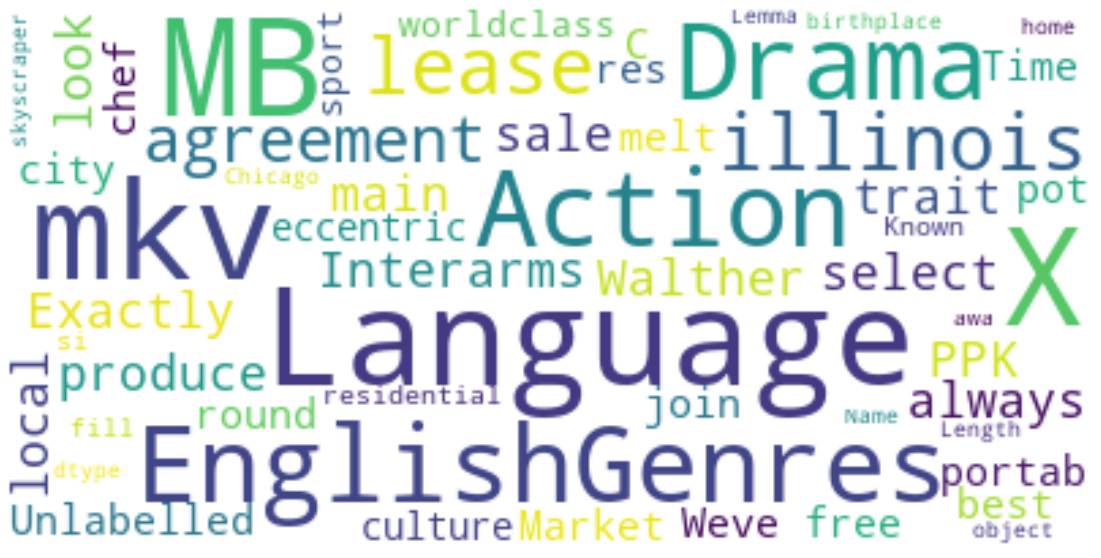

In [149]:
# Most prominent positive words
import matplotlib.pyplot as plt
from wordcloud import WordCloud
positive = df[df['Vader Analysis']=='Positive']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(positive['Lemma']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

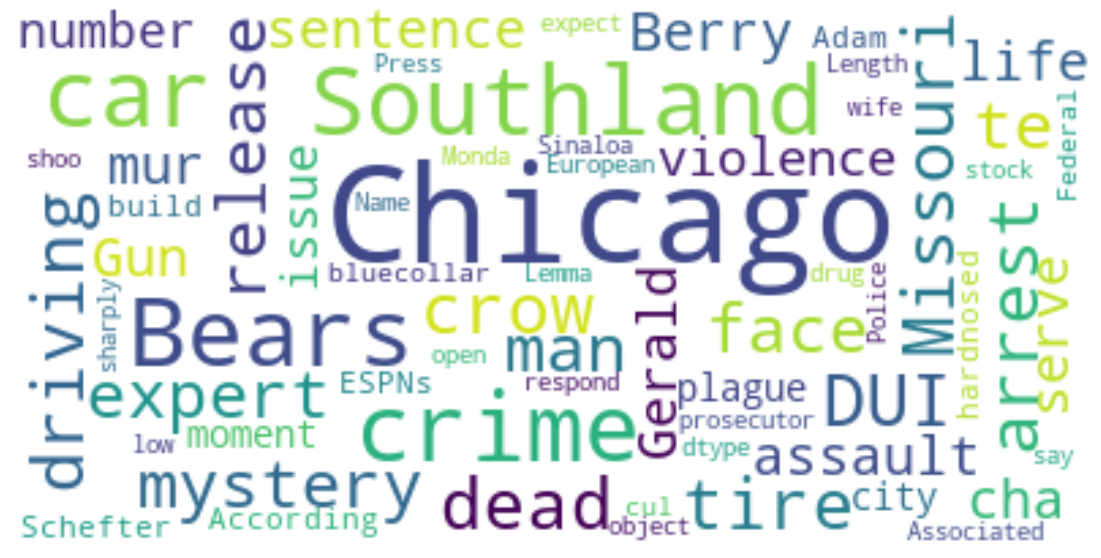

In [153]:
# Most prominent negative words
import matplotlib.pyplot as plt
from wordcloud import WordCloud
negative = df[df['Vader Analysis']=='Negative']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(negative['Lemma']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [4]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [8]:
# df.to_csv('data.csv')
# !cp data.csv "drive/My Drive/"

In [5]:
df=pd.read_csv('/content/drive/My Drive/data.csv').drop("Unnamed: 0", axis=1)

In [6]:
df.sample(30)

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis
85033,2022-06-28,english,2022 Illinois Primary Election Live Updates: P...,The Illinois Primary Election has been underwa...,"[('Illinois', 'n'), ('Primary', 'n'), ('Electi...",Illinois Primary Election underway week earl...,0.381232,0.125370,Positive,0.9083,Positive
87372,2022-03-16,english,Grading the Bears signing of LB Nicholas Morro...,The Chicago Bears added to their revamped defe...,"[('Chicago', 'n'), ('Bears', 'n'), ('added', '...",Chicago Bears add revamp defense Tuesday eve...,0.400577,0.072821,Positive,0.9235,Positive
146971,2022-07-02,english,Business Agribusiness Loans in Illinois,Illinois Vitality Conservation Authority Close...,"[('Illinois', 'n'), ('Vitality', 'n'), ('Conse...",Illinois Vitality Conservation Authority Clo...,0.387739,0.115202,Positive,0.9997,Positive
97827,2022-02-27,english,Potent Protest: Michigan Bar Drops Russian Vod...,Potent Protest Michigan Bar Drops Russian Vodk...,"[('Potent', 'a'), ('Protest', 'n'), ('Michigan...",Potent Protest Michigan Bar Drops Russian Vo...,0.368750,0.215625,Positive,0.9652,Positive
83282,2022-04-27,english,Illinois Agility Run for Beginners,Illinois Area Code Truths Table of ContentsThe...,"[('Illinois', 'n'), ('Area', 'n'), ('Code', 'n...",Illinois Area Code Truths Table ContentsThe ...,0.738095,0.323810,Positive,0.8957,Positive
95702,2022-02-11,english,BC Family Medicine Faculty Job in Suburban Ill...,BC Family Medicine Faculty Job in Suburban Ill...,"[('BC', 'n'), ('Family', 'n'), ('Medicine', 'n...",BC Family Medicine Faculty Job Suburban Illi...,0.369139,0.033333,Positive,0.9590,Positive
117118,2022-03-18,english,"Toronto Marlies Chicago Wolves, Mar 19, 2022 ...",AHL Saturday pm ETScore HighlightsProbability ...,"[('AHL', 'n'), ('Saturday', 'n'), ('pm', 'v'),...",AHL Saturday pm ETScore HighlightsProbabilit...,0.547222,0.153283,Positive,0.9918,Positive
141373,2022-01-13,english,The 9Minute Rule for Illinois Employment Lawyers,The Minute Rule for Illinois Employment Lawyer...,"[('Minute', 'n'), ('Rule', 'n'), ('Illinois', ...",Minute Rule Illinois Employment LawyersTable...,0.489218,0.134771,Positive,0.9987,Positive
85299,2022-02-25,english,Bath Body Works Black History Month Collectio...,A Bath Body Works spokesperson said the compan...,"[('Bath', 'n'), ('Body', 'n'), ('Works', 'n'),...",Bath Body Works spokesperson say company col...,0.308718,0.012338,Positive,0.9100,Positive
21440,2022-03-14,english,Two tornadoes confirmed in Central Illinois fr...,FARMERSVILLE Ill WCIA Two tornadoes were confi...,"[('FARMERSVILLE', 'n'), ('Ill', 'n'), ('WCIA',...",FARMERSVILLE Ill WCIA tornado confirm Centra...,0.333333,0.082456,Positive,-0.8852,Negative


In [7]:

# Python code to convert string to list
 
def Convert(string):
    li = list(string.split(" "))
    return li
 
  
df['title list'] = df['title'].apply(Convert)
df

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list
0,2022-05-25,english,Southland crime: DUI arrest after car driving ...,Southland crime DUI arrest after car driving o...,"[('Southland', 'n'), ('crime', 'n'), ('DUI', '...",Southland crime DUI arrest car driving tire ...,0.156292,-0.035046,Negative,-1.0,Negative,"[Southland, crime:, DUI, arrest, after, car, d..."
1,2022-02-18,english,Illinois counties with the highest COVID19 dea...,Missouri dead crow mystery experts release tes...,"[('Missouri', 'n'), ('dead', 'a'), ('crow', 'n...",Missouri dead crow mystery expert release te...,0.426691,-0.013757,Negative,-1.0,Negative,"[Illinois, counties, with, the, highest, COVID..."
2,2022-02-09,english,"Southland crime: Chicago man faces weapon, ass...",Southland crime Chicago man faces weapon assau...,"[('Southland', 'n'), ('crime', 'n'), ('Chicago...",Southland crime Chicago man face assault cha...,0.158635,-0.066773,Negative,-1.0,Negative,"[Southland, crime:, Chicago, man, faces, weapo..."
3,2022-01-29,english,Illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[('CHICAGO', 'n'), ('Gerald', 'n'), ('Berry', ...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0,Negative,"[Illinois, change, in, felony, murder, rule, l..."
4,2022-06-22,english,Governing Through Gun Crime: How Chicago Funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago..."
...,...,...,...,...,...,...,...,...,...,...,...,...
147775,2022-01-03,english,55 Best Things to Do in Chicago According to L...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord..."
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia..."
147777,2022-02-12,english,50 Best Places to Visit in Chicago TourScanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T..."
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill..."


In [8]:
df

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list
0,2022-05-25,english,Southland crime: DUI arrest after car driving ...,Southland crime DUI arrest after car driving o...,"[('Southland', 'n'), ('crime', 'n'), ('DUI', '...",Southland crime DUI arrest car driving tire ...,0.156292,-0.035046,Negative,-1.0,Negative,"[Southland, crime:, DUI, arrest, after, car, d..."
1,2022-02-18,english,Illinois counties with the highest COVID19 dea...,Missouri dead crow mystery experts release tes...,"[('Missouri', 'n'), ('dead', 'a'), ('crow', 'n...",Missouri dead crow mystery expert release te...,0.426691,-0.013757,Negative,-1.0,Negative,"[Illinois, counties, with, the, highest, COVID..."
2,2022-02-09,english,"Southland crime: Chicago man faces weapon, ass...",Southland crime Chicago man faces weapon assau...,"[('Southland', 'n'), ('crime', 'n'), ('Chicago...",Southland crime Chicago man face assault cha...,0.158635,-0.066773,Negative,-1.0,Negative,"[Southland, crime:, Chicago, man, faces, weapo..."
3,2022-01-29,english,Illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[('CHICAGO', 'n'), ('Gerald', 'n'), ('Berry', ...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0,Negative,"[Illinois, change, in, felony, murder, rule, l..."
4,2022-06-22,english,Governing Through Gun Crime: How Chicago Funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago..."
...,...,...,...,...,...,...,...,...,...,...,...,...
147775,2022-01-03,english,55 Best Things to Do in Chicago According to L...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord..."
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia..."
147777,2022-02-12,english,50 Best Places to Visit in Chicago TourScanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T..."
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill..."


In [9]:
my_list = ['southland']
df['title'] = df['title'].str.lower()
df['title drop South'] = df['title'].str.contains(*my_list)

In [10]:
df

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South
0,2022-05-25,english,southland crime: dui arrest after car driving ...,Southland crime DUI arrest after car driving o...,"[('Southland', 'n'), ('crime', 'n'), ('DUI', '...",Southland crime DUI arrest car driving tire ...,0.156292,-0.035046,Negative,-1.0,Negative,"[Southland, crime:, DUI, arrest, after, car, d...",True
1,2022-02-18,english,illinois counties with the highest covid19 dea...,Missouri dead crow mystery experts release tes...,"[('Missouri', 'n'), ('dead', 'a'), ('crow', 'n...",Missouri dead crow mystery expert release te...,0.426691,-0.013757,Negative,-1.0,Negative,"[Illinois, counties, with, the, highest, COVID...",False
2,2022-02-09,english,"southland crime: chicago man faces weapon, ass...",Southland crime Chicago man faces weapon assau...,"[('Southland', 'n'), ('crime', 'n'), ('Chicago...",Southland crime Chicago man face assault cha...,0.158635,-0.066773,Negative,-1.0,Negative,"[Southland, crime:, Chicago, man, faces, weapo...",True
3,2022-01-29,english,illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[('CHICAGO', 'n'), ('Gerald', 'n'), ('Berry', ...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0,Negative,"[Illinois, change, in, felony, murder, rule, l...",False
4,2022-06-22,english,governing through gun crime: how chicago funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147775,2022-01-03,english,55 best things to do in chicago according to l...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord...",False
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia...",False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill...",False


In [11]:
dfdrop = df.copy

In [12]:

df = df[df['title drop South'] == False] 

In [13]:
df

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South
1,2022-02-18,english,illinois counties with the highest covid19 dea...,Missouri dead crow mystery experts release tes...,"[('Missouri', 'n'), ('dead', 'a'), ('crow', 'n...",Missouri dead crow mystery expert release te...,0.426691,-0.013757,Negative,-1.0,Negative,"[Illinois, counties, with, the, highest, COVID...",False
3,2022-01-29,english,illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[('CHICAGO', 'n'), ('Gerald', 'n'), ('Berry', ...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0,Negative,"[Illinois, change, in, felony, murder, rule, l...",False
4,2022-06-22,english,governing through gun crime: how chicago funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago...",False
5,2022-01-06,english,chicago fire s10e10 720p web h264peculate,Chicago Fire S E p WEB H PECULATEFeel free to ...,"[('Chicago', 'n'), ('Fire', 'n'), ('E', 'n'), ...",Chicago Fire E p WEB H PECULATEFeel free pos...,0.149519,0.076442,Positive,-1.0,Negative,"[Chicago, Fire, S10E10, 720p, WEB, H264PECULATE]",False
6,2022-01-17,english,black lives murder at least 29 shot during we...,At Least Shot During Weekend in Mayor Lori Lig...,"[('Least', 'n'), ('Shot', 'n'), ('Weekend', 'n...",Least Shot Weekend Mayor Lori Lightfoots Chi...,0.390429,-0.042565,Negative,-1.0,Negative,"[BLACK, LIVES, MURDER, , At, Least, 29, Shot, ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147775,2022-01-03,english,55 best things to do in chicago according to l...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord...",False
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia...",False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill...",False


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147746 entries, 1 to 147779
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              147746 non-null  object 
 1   language          147746 non-null  object 
 2   title             147746 non-null  object 
 3   text              147745 non-null  object 
 4   POS tagged        147746 non-null  object 
 5   Lemma             147746 non-null  object 
 6   Subjectivity      147746 non-null  float64
 7   Polarity          147746 non-null  float64
 8   Analysis          147746 non-null  object 
 9   Vader Sentiment   147746 non-null  float64
 10  Vader Analysis    147746 non-null  object 
 11  title list        147746 non-null  object 
 12  title drop South  147746 non-null  bool   
dtypes: bool(1), float64(3), object(9)
memory usage: 14.8+ MB


In [15]:
# my_list=['Chicago']
# df['title Chicago'] = df['title'].str.contains(*my_list)

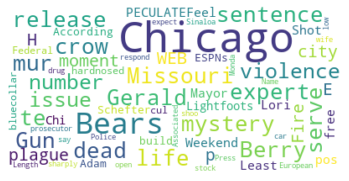

In [20]:
#Checking without Southland, etc. 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(["Southland", "relea", "items", "dtype",'Lemma', 'take', 'object']) #adding our own stopwords
negative = df[df['Vader Analysis']=='Negative']
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white", stopwords = stopwords).generate(str(negative['Lemma']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
!pip install rake_nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from rake_nltk import Rake

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

def rake_implement(x,r):
    r.extract_keywords_from_text(x) # r.extract_keywords_from_text(<text to process>)
    return r.get_ranked_phrases() # r.get_ranked_phrases() # To get keyword phrases ranked highest to lowest.

In [21]:
df['text']=df['text'].astype(str)

In [24]:
# df['rake_phrases']=df['text'].apply(lambda x: rake_implement(x,r))

In [25]:
df

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South,title Chicago
1,2022-02-18,english,illinois counties with the highest covid19 dea...,Missouri dead crow mystery experts release tes...,"[('Missouri', 'n'), ('dead', 'a'), ('crow', 'n...",Missouri dead crow mystery expert release te...,0.426691,-0.013757,Negative,-1.0,Negative,"[Illinois, counties, with, the, highest, COVID...",False,False
3,2022-01-29,english,illinois change in felony murder rule left som...,CHICAGO Gerald Berry is serving a life sentenc...,"[('CHICAGO', 'n'), ('Gerald', 'n'), ('Berry', ...",CHICAGO Gerald Berry serve life sentence mur...,0.433960,0.029593,Positive,-1.0,Negative,"[Illinois, change, in, felony, murder, rule, l...",False,False
4,2022-06-22,english,governing through gun crime: how chicago funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago...",False,False
5,2022-01-06,english,chicago fire s10e10 720p web h264peculate,Chicago Fire S E p WEB H PECULATEFeel free to ...,"[('Chicago', 'n'), ('Fire', 'n'), ('E', 'n'), ...",Chicago Fire E p WEB H PECULATEFeel free pos...,0.149519,0.076442,Positive,-1.0,Negative,"[Chicago, Fire, S10E10, 720p, WEB, H264PECULATE]",False,False
6,2022-01-17,english,black lives murder at least 29 shot during we...,At Least Shot During Weekend in Mayor Lori Lig...,"[('Least', 'n'), ('Shot', 'n'), ('Weekend', 'n...",Least Shot Weekend Mayor Lori Lightfoots Chi...,0.390429,-0.042565,Negative,-1.0,Negative,"[BLACK, LIVES, MURDER, , At, Least, 29, Shot, ...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147775,2022-01-03,english,55 best things to do in chicago according to l...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord...",False,False
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia...",False,False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False,False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill...",False,False


## Text Summarization on Positive Articles

In [26]:
df.sort_values(by='Vader Sentiment', ascending=False, inplace=True)


In [27]:
df.sort_values(by='Vader Sentiment', ascending=False, inplace=True)
df.head(30)

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South,title Chicago
147779,2022-06-23,english,trending news: 24 top weekend getaways from ch...,Known as the birthplace of the skyscraper Chic...,"[('Known', 'v'), ('birthplace', 'n'), ('skyscr...",Known birthplace skyscraper Chicago home awa...,0.502819,0.241322,Positive,1.0,Positive,"[Trending, news:, 24, Top, Weekend, Getaways, ...",False,False
147759,2022-05-04,english,illinois tool works inc. itw q1 2022 earnings ...,Categories Earnings Call Transcripts Industria...,"[('Categories', 'n'), ('Earnings', 'n'), ('Cal...",Categories Earnings Call Transcripts Industr...,0.452550,0.116813,Positive,1.0,Positive,"[Illinois, Tool, Works, Inc., ITW, Q1, 2022, E...",False,False
147739,2022-07-17,english,episode 45: visiting with joan zernich and her...,Episode Visiting with Joan Zernich and her sto...,"[('Episode', 'n'), ('Visiting', 'v'), ('Joan',...",Episode Visiting Joan Zernich story Ask Joan...,0.533475,0.243613,Positive,1.0,Positive,"[Episode, 45:, Visiting, with, Joan, Zernich, ...",False,False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill...",False,False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False,False
147776,2022-04-29,english,free illinois lease agreements residential com...,Unlabelled free illinois lease agreements resi...,"[('Unlabelled', 'v'), ('free', 'a'), ('illinoi...",Unlabelled free illinois lease agreement res...,0.426471,0.146627,Positive,1.0,Positive,"[free, illinois, lease, agreements, residentia...",False,False
147775,2022-01-03,english,55 best things to do in chicago according to l...,Weve rounded up the best chefs in the city to ...,"[('Weve', 'n'), ('rounded', 'v'), ('best', 'a'...",Weve round best chef city join Time Market C...,0.457785,0.191205,Positive,1.0,Positive,"[55, Best, Things, to, Do, in, Chicago, Accord...",False,False
147774,2022-06-05,english,2765644446327603591146 psychic love spell cast...,Recipe Directions EFFECTIVE LOST LOVE SPELL CA...,"[('Recipe', 'n'), ('Directions', 'n'), ('EFFEC...",Recipe Directions EFFECTIVE LOST LOVE SPELL ...,0.592771,0.300362,Positive,1.0,Positive,"[2765644446327603591146, PSYCHIC, LOVE, SPELL,...",False,False
147773,2022-07-09,english,how to be a met fan in chicago 2022 edition,Next Thursday after the AllStar Break the Mets...,"[('Next', 'a'), ('Thursday', 'n'), ('AllStar',...",Next Thursday AllStar Break Mets begin game ...,0.396179,0.097524,Positive,1.0,Positive,"[How, to, Be, a, Met, Fan, In, Chicago, , 2022...",False,False
147772,2022-03-03,english,"top 11 airbnb vacation rentals in bartlett, il...",Bartlett is a suburb of the windy city of Chic...,"[('Bartlett', 'n'), ('suburb', 'n'), ('windy',...",Bartlett suburb windy city Chicago locate so...,0.618767,0.353138,Positive,1.0,Positive,"[Top, 11, Airbnb, Vacation, Rentals, In, Bartl...",False,False


In [34]:
text = str(df['text'].tolist())
text[:1000]

"['Known as the birthplace of the skyscraper Chicago is home to awardwinning restaurants top sports teams and prized cultural treasures But when you need a break from the excitement of the nations third largest city there are countless getaways within easy driving distance You can explore rural Illinois or enjoy neighboring Indiana Wisconsin Iowa or Michigan all within a weekend Whether youre planning a romantic getaway to a smalltown bedandbreakfast or a familyfriendly trip to a water park resort these nearby Midwest destinations will relieve the stress of big city life Note Some of the following activities attractions and locations may be affected by the COVID pandemic New policies may be in place including capacity restrictions reservation requirements or mask mandates Check with the Centers for Disease Control and Prevention the U S Department of State and local tourism boards before traveling Best Weekend Getaways from Chicago About two hours or less Fox River Valley Illinois Harb

In [29]:
df4 = df['text']

In [ ]:
text = df4[147775]

In [39]:
# keywords = summa.keywords.keywords(text)
# print(keywords)

In [69]:
text = text = df4[118475]

In [70]:
keywords = summa.keywords.keywords(text)
print(keywords)

teachers
teacher
union
chicago
chicagos
school
schools
cases
safe
ctu
video
intoned
intoning
return
cps
cpss
teaching
disclosure
children
needs returned
beacon reported
dance
need
juarez
community
jesse
sharkey
fastestgrowing conservative media
positivity


In [36]:
pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
 import summa
# %time 
# textSum = summa.summarizer.summarize(text, ratio=0.003)
# print(textSum)


In [43]:
df.drop('title Chicago', axis=1)

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South
147779,2022-06-23,english,trending news: 24 top weekend getaways from ch...,Known as the birthplace of the skyscraper Chic...,"[('Known', 'v'), ('birthplace', 'n'), ('skyscr...",Known birthplace skyscraper Chicago home awa...,0.502819,0.241322,Positive,1.0,Positive,"[Trending, news:, 24, Top, Weekend, Getaways, ...",False
147759,2022-05-04,english,illinois tool works inc. itw q1 2022 earnings ...,Categories Earnings Call Transcripts Industria...,"[('Categories', 'n'), ('Earnings', 'n'), ('Cal...",Categories Earnings Call Transcripts Industr...,0.452550,0.116813,Positive,1.0,Positive,"[Illinois, Tool, Works, Inc., ITW, Q1, 2022, E...",False
147739,2022-07-17,english,episode 45: visiting with joan zernich and her...,Episode Visiting with Joan Zernich and her sto...,"[('Episode', 'n'), ('Visiting', 'v'), ('Joan',...",Episode Visiting Joan Zernich story Ask Joan...,0.533475,0.243613,Positive,1.0,Positive,"[Episode, 45:, Visiting, with, Joan, Zernich, ...",False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0,Positive,"[illinois, residential, lease, agreement, fill...",False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2022-01-17,english,black lives murder at least 29 shot during we...,At Least Shot During Weekend in Mayor Lori Lig...,"[('Least', 'n'), ('Shot', 'n'), ('Weekend', 'n...",Least Shot Weekend Mayor Lori Lightfoots Chi...,0.390429,-0.042565,Negative,-1.0,Negative,"[BLACK, LIVES, MURDER, , At, Least, 29, Shot, ...",False
5,2022-01-06,english,chicago fire s10e10 720p web h264peculate,Chicago Fire S E p WEB H PECULATEFeel free to ...,"[('Chicago', 'n'), ('Fire', 'n'), ('E', 'n'), ...",Chicago Fire E p WEB H PECULATEFeel free pos...,0.149519,0.076442,Positive,-1.0,Negative,"[Chicago, Fire, S10E10, 720p, WEB, H264PECULATE]",False
4,2022-06-22,english,governing through gun crime: how chicago funde...,Gun violence is the number one issue plaguing ...,"[('Gun', 'n'), ('violence', 'n'), ('number', '...",Gun violence number issue plague city moment...,0.416002,0.021852,Positive,-1.0,Negative,"[Governing, Through, Gun, Crime:, How, Chicago...",False
11,2022-03-05,english,counties with highest covid19 infection rates ...,Woman pleads for help finding missing husband ...,"[('Woman', 'n'), ('pleads', 'v'), ('help', 'n'...",Woman plead help find miss husband Jefferson...,0.469115,-0.026726,Negative,-1.0,Negative,"[Counties, with, highest, COVID19, infection, ...",False


ENTITY ANALYSIS 

In [81]:
# def label2(text):
    
    
#       entities = []
#       labels = []
#       for sent in nltk.sent_tokenize(text):
#           for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
#               if hasattr(chunk, 'label'):
#                   entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
#                   labels.append(chunk.label())

#       #entities_labels = list(zip(entities, labels))
#       entities_labels = list(set(zip(entities, labels))) #unique entities
#       entities_df = pd.DataFrame(entities_labels)
#       if entities_df.empty:
#           return pd.DataFrame({'Entities':[], 'Labels':[], 'Count':[]})
#       else:
#           entities_df.columns = ["Entities", "Labels"]
#           entities_df = entities_df.groupby(["Entities", "Labels"]).size().reset_index(name='Count')
#           entities_df = entities_df.sort_values('Count', ascending=False)
#           #Filtering out for just organization since we want companies
#           #entities_df = entities_df[entities_df.Labels == 'ORGANIZATION']
#           return entities_df
#     else:
#         return pd.DataFrame({'Entities':[], 'Labels':[], 'Count':[]})

In [91]:
def label2(text):
    entities = []
    labels = []

    for sent in nltk.sent_tokenize(text):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
            if hasattr(chunk, 'label'):
                entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
                labels.append(chunk.label())

    #entities_labels = list(zip(entities, labels))
    entities_labels = list(set(zip(entities, labels))) #unique entities
    entities_df = pd.DataFrame(entities_labels)
    if entities_df.empty:
        return pd.DataFrame({'Entities':[], 'Labels':[], 'Count':[]})
    else:
        entities_df.columns = ["Entities", "Labels"]
        entities_df = entities_df.groupby(["Entities", "Labels"]).size().reset_index(name='Count')
        entities_df = entities_df.sort_values('Count', ascending=False)
        #Filtering out for just organization since we want companies
        #entities_df = entities_df[entities_df.Labels == 'ORGANIZATION']
        return entities_df


In [92]:
df.title

147779    trending news: 24 top weekend getaways from ch...
147759    illinois tool works inc. itw q1 2022 earnings ...
147739    episode 45: visiting with joan zernich and her...
147778    illinois residential lease agreement fill out ...
147777      50 best places to visit in chicago  tourscanner
                                ...                        
6         black lives murder  at least 29 shot during we...
5                 chicago fire s10e10 720p web h264peculate
4         governing through gun crime: how chicago funde...
11        counties with highest covid19 infection rates ...
1         illinois counties with the highest covid19 dea...
Name: title, Length: 147746, dtype: object

In [93]:
df['title'] = df['title'].astype('str') 

In [54]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [56]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [58]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [95]:
label2(df.text.iloc[0])

,Entities,Labels,Count
0,AAAs,ORGANIZATION,1
184,Museum Hotel Louisville,PERSON,1
190,National Register,ORGANIZATION,1
189,National Mississippi River Museum,ORGANIZATION,1
188,National Blues Museum,ORGANIZATION,1
...,...,...,...
99,Hotel Julien Dubuque,PERSON,1
100,House,ORGANIZATION,1
101,Hurricane Harbor,PERSON,1
102,Idler Riverboat,PERSON,1


In [64]:
positive_df = df[df['Vader Analysis'] == 'Positive']

In [171]:
df5 = positive_df[:10000]

In [172]:
def dom_entity(ldf):
    dominant = ldf.groupby(['Entities']).agg({'Labels' : lambda x: x.iloc[0], 'Count' : 'sum', }).reset_index()
    return dominant
    

In [173]:
# text_labels_dfs = []
# title_labels_dfs = []

# for i, row in df5.iterrows():
#     text_l= label2(row['text'])
#     text_labels = dom_entity(text_l) 
#     text_labels['n_articles'] = 1
#     text_labels_dfs.append(text_labels)
    
#     title_l = label2(row['title'])
#     title_labels = dom_entity(title_l)
#     title_labels['n_articles'] = 1
#     title_labels_dfs.append(title_labels)
    
# df_text2  = pd.concat(text_labels_dfs)
# df_title2 = pd.concat(title_labels_dfs)

In [174]:
# df_title2=df_title2.groupby(['Entities', 'Labels'])\
#         .agg({'Count':'sum','n_articles': 'sum'})\
#         .reset_index()
# df_title2.sort_values('n_articles', ascending=False, inplace=True)
# df_title2.head(20)


In [175]:
# df_text2=df_text2.groupby(['Entities', 'Labels'])\
#         .agg({'Count':'sum', 'n_articles': 'sum'})\
#         .reset_index()
# df_text2.sort_values('n_articles', ascending=False, inplace=True)
# df_text2.head(20)

Spacy

In [176]:
import spacy 
nlp = spacy.load("en_core_web_sm")

In [177]:
def label2_spacy(text):
    final_df = pd.DataFrame({'Entities':[], 'Labels':[], 'Position_Start':[], 'Position_End':[],'Count':[]})
    if 'chicago' in text.lower(): 

      doc = nlp(text)

      entities = []
      labels = []
      position_start = []
      position_end = []
      df = pd.DataFrame({'Entities':[], 'Labels':[], 'Position_Start':[], 'Position_End':[],'Count':[]})
      for sent in doc.sents:
        for ent in doc.ents:
          entities.append(ent.text)
          labels.append(ent.label_)
          position_start.append(ent.start_char)
          position_end.append(ent.end_char)
    
      df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
      if not df.empty:
        df.columns = ["Entities", "Labels", "Position_Start", "Position_End"]
        df = df.groupby(["Entities", "Labels"]).size().reset_index(name='Count')
        df = df.sort_values('Count', ascending=False)
        final_df = df

    return final_df.head(20)

In [178]:
label2_spacy(df.Lemma.iloc[0])

,Entities,Labels,Count
27,Chicago,GPE,741
221,Wisconsin,GPE,351
130,Midwest,LOC,234
244,summer,DATE,234
140,Mississippi River,LOC,195
124,Michigan,GPE,156
134,Milwaukee,GPE,117
83,Illinois,GPE,117
49,Fox River,LOC,117
115,Louisville,GPE,117


In [179]:
df5

,date,language,title,text,POS tagged,Lemma,Subjectivity,Polarity,Analysis,Vader Sentiment,Vader Analysis,title list,title drop South,title Chicago
147779,2022-06-23,english,trending news: 24 top weekend getaways from ch...,Known as the birthplace of the skyscraper Chic...,"[('Known', 'v'), ('birthplace', 'n'), ('skyscr...",Known birthplace skyscraper Chicago home awa...,0.502819,0.241322,Positive,1.0000,Positive,"[Trending, news:, 24, Top, Weekend, Getaways, ...",False,False
147759,2022-05-04,english,illinois tool works inc. itw q1 2022 earnings ...,Categories Earnings Call Transcripts Industria...,"[('Categories', 'n'), ('Earnings', 'n'), ('Cal...",Categories Earnings Call Transcripts Industr...,0.452550,0.116813,Positive,1.0000,Positive,"[Illinois, Tool, Works, Inc., ITW, Q1, 2022, E...",False,False
147739,2022-07-17,english,episode 45: visiting with joan zernich and her...,Episode Visiting with Joan Zernich and her sto...,"[('Episode', 'n'), ('Visiting', 'v'), ('Joan',...",Episode Visiting Joan Zernich story Ask Joan...,0.533475,0.243613,Positive,1.0000,Positive,"[Episode, 45:, Visiting, with, Joan, Zernich, ...",False,False
147778,2022-02-02,english,illinois residential lease agreement fill out ...,illinois residential lease agreement fill out ...,"[('illinois', 'n'), ('residential', 'a'), ('le...",illinois residential lease agreement fill si...,0.443834,0.223085,Positive,1.0000,Positive,"[illinois, residential, lease, agreement, fill...",False,False
147777,2022-02-12,english,50 best places to visit in chicago tourscanner,A melting pot of eccentric culture worldclass ...,"[('melting', 'v'), ('pot', 'n'), ('eccentric',...",melt pot eccentric culture worldclass sport ...,0.486747,0.249468,Positive,1.0000,Positive,"[50, Best, Places, to, Visit, in, Chicago, , T...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137790,2022-05-19,english,practifi announces ondemand learning platform ...,PractifiU provides wealth management firms per...,"[('PractifiU', 'n'), ('provides', 'v'), ('weal...",PractifiU provide wealth management firm per...,0.494662,0.158397,Positive,0.9981,Positive,"[Practifi, Announces, OnDemand, Learning, Plat...",False,False
137725,2022-03-06,english,theyve meant the world to me: underwood reflec...,Theyve meant the world to me Underwood reflect...,"[('Theyve', 'n'), ('meant', 'v'), ('world', 'n...",Theyve mean world Underwood reflect Senior N...,0.425841,0.108264,Positive,0.9981,Positive,"[Theyve, meant, the, world, to, me:, Underwood...",False,False
137760,2022-01-14,english,roofing chicago things to know before you get ...,Roofing Chicago Things To Know Before You Get ...,"[('Roofing', 'v'), ('Chicago', 'n'), ('Things'...",Roofing Chicago Things Know Get ThisThe Seco...,0.479285,0.154382,Positive,0.9981,Positive,"[Roofing, Chicago, Things, To, Know, Before, Y...",False,False
137778,2022-03-15,english,chicago and its river turn green for the the 6...,Chicago and its river turn green for the the t...,"[('Chicago', 'n'), ('river', 'n'), ('turn', 'v...",Chicago river turn green th annual St Patric...,0.267003,0.004368,Positive,0.9981,Positive,"[Chicago, and, its, river, turn, green, for, t...",False,False


In [180]:
text_labels_dfs = []
title_labels_dfs = []
lemma_labels_dfs = []

for i, row in df5.iterrows():
    text_l= label2_spacy(row['text'])
    text_labels = dom_entity(text_l) 
    text_labels['n_articles'] = 1
    text_labels_dfs.append(text_labels)
    
    title_l = label2_spacy(row['title'])
    title_labels = dom_entity(title_l)
    title_labels['n_articles'] = 1
    title_labels_dfs.append(title_labels)

    lemma_l = label2_spacy(row['Lemma'])
    lemma_labels = dom_entity(lemma_l)
    lemma_labels['n_articles'] = 1
    lemma_labels_dfs.append(lemma_labels)
    
df_text3  = pd.concat(text_labels_dfs)
df_title3 = pd.concat(title_labels_dfs)
df_lemma3 = pd.concat(lemma_labels_dfs)

In [181]:
df_title3=df_title3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_title3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Organization 
df_title3 = df_title3[df_title3.Labels == 'ORG']
df_title3.head(50)

,Entities,Labels,Count,n_articles
1990,nbc,ORG,246.0,230
2070,nyse,ORG,106.0,100
1351,gm,ORG,85.0,62
1364,greater chicago,ORG,59.0,59
977,chicago trust co na,ORG,65.0,57
1365,greater chicago roofing,ORG,30.0,30
823,boston herald,ORG,37.0,22
884,cbs,ORG,22.0,22
1001,chicago trust co na sells,ORG,21.0,20
606,abc7,ORG,21.0,20


In [182]:
df_title3=df_title3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_title3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Person
df_title3 = df_title3[df_title3.Labels == 'PERSON']
df_title3.head(50)

,Entities,Labels,Count,n_articles


In [183]:
df_text3=df_text3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_text3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Organization 
df_text3 = df_text3[df_text3.Labels == 'ORG']
df_text3.head(50)

,Entities,Labels,Count,n_articles
10760,Greater Chicago Roofing,ORG,5690.0,346
19400,NFL,ORG,67158.0,314
12025,Greater Chicago Roofing Wheaton,ORG,4495.0,221
7077,Cubs,ORG,54833.0,212
26783,SEC,ORG,4758.0,174
33897,The Definitive Guide,ORG,1509.0,146
39525,U S,ORG,6968.0,144
31213,StockNews,ORG,2362.0,141
9973,GM,ORG,29300.0,133
19333,NBA,ORG,20498.0,128


In [184]:
df_text3=df_text3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_text3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for person 
df_text3 = df_text3[df_text3.Labels == 'PERSON']
df_text3.head(50)

,Entities,Labels,Count,n_articles


In [185]:
df_lemma3=df_lemma3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_lemma3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for person
df_lemma3 = df_lemma3[df_lemma3.Labels == 'PERSON']
df_lemma3.head(50)



,Entities,Labels,Count,n_articles
39605,Ryan Poles,PERSON,17191.0,196
3382,Bears,PERSON,34049.0,192
12190,Framed Prints,PERSON,3130.0,113
32760,Photo Prints,PERSON,1565.0,113
24157,Matt Eberflus,PERSON,9707.0,106
2059,Anniversarygalleriesanniversary Arrivalgalleri...,PERSON,1330.0,96
21322,Lets,PERSON,1233.0,91
8809,Davis,PERSON,5685.0,90
44486,Split,PERSON,1021.0,87
4162,Blackhawks,PERSON,10055.0,78


Entity Identity - Negative Sentiment

In [190]:
df_neg = df[df['Vader Analysis']== 'Negative']
df_neg = df_neg[:10000]

In [191]:
text_labels_dfs = []
title_labels_dfs = []
lemma_labels_dfs = []

for i, row in df_neg.iterrows():
    text_l= label2_spacy(row['text'])
    text_labels = dom_entity(text_l) 
    text_labels['n_articles'] = 1
    text_labels_dfs.append(text_labels)
    
    title_l = label2_spacy(row['title'])
    title_labels = dom_entity(title_l)
    title_labels['n_articles'] = 1
    title_labels_dfs.append(title_labels)

    lemma_l = label2_spacy(row['Lemma'])
    lemma_labels = dom_entity(lemma_l)
    lemma_labels['n_articles'] = 1
    lemma_labels_dfs.append(lemma_labels)
    
df_text3  = pd.concat(text_labels_dfs)
df_title3 = pd.concat(title_labels_dfs)
df_lemma3 = pd.concat(lemma_labels_dfs)

In [192]:
df_title3=df_title3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_title3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Organization 
df_title3 = df_title3[df_title3.Labels == 'ORG']
df_title3.head(50)

,Entities,Labels,Count,n_articles
1551,cbs,ORG,425.0,414
2730,nbc,ORG,394.0,386
1590,chicago chicago,ORG,118.0,57
1254,abc7,ORG,36.0,36
1251,abc,ORG,45.0,34
2055,gm,ORG,37.0,33
1671,chicago teachers union,ORG,23.0,23
1963,fbi,ORG,27.0,22
1777,cpd,ORG,27.0,21
2727,nba,ORG,19.0,19


In [194]:
df_title3=df_title3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_title3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Organization 
df_title3 = df_title3[df_title3.Labels == 'PERSON']
df_title3.head(50)

,Entities,Labels,Count,n_articles


In [193]:
df_text3=df_text3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_text3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for Organization 
df_text3 = df_text3[df_text3.Labels == 'ORG']
df_text3.head(50)

,Entities,Labels,Count,n_articles
2218,CBS,ORG,1297.0,229
10869,NBC,ORG,1708.0,134
10930,NFL,ORG,1725.0,109
17525,U S,ORG,777.0,107
4106,Cubs,ORG,3240.0,90
2464,CPS,ORG,1807.0,87
16117,The Associated Press,ORG,325.0,84
2455,CPD,ORG,485.0,80
22324,the Chicago Teachers Union,ORG,384.0,72
169,AP,ORG,440.0,67


In [195]:
df_text3=df_text3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_text3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for person 
df_text3 = df_text3[df_text3.Labels == 'PERSON']
df_text3.head(50)

,Entities,Labels,Count,n_articles


In [196]:
df_lemma3=df_lemma3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_lemma3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for person
df_lemma3 = df_lemma3[df_lemma3.Labels == 'PERSON']
df_lemma3.head(50)



,Entities,Labels,Count,n_articles
11467,Lori Lightfoot,PERSON,1604.0,231
20788,Twitter,PERSON,593.0,109
11219,Lightfoot,PERSON,1306.0,106
23001,Zach LaVine,PERSON,651.0,92
15837,Pritzker,PERSON,1686.0,90
4482,Compat,PERSON,364.0,64
23912,harry lu announce minute,PERSON,886.0,63
557,Alex Caruso,PERSON,624.0,62
1902,Blackhawks,PERSON,571.0,62
17323,Ryan Poles,PERSON,501.0,52


In [200]:
df_lemma3=df_lemma3.groupby(['Entities', 'Labels'])\
        .agg({'Count':'sum','n_articles': 'sum'})\
        .reset_index()
df_lemma3.sort_values('n_articles', ascending=False, inplace=True)
#Filtering out for person
df_lemma3 = df_lemma3[df_lemma3.Labels == 'LOC']
df_lemma3.head(50)


,Entities,Labels,Count,n_articles


## Executive Summary

The demographic landscape of Illinois in 2021, as per Census.gov, revealed a significant domestic migration loss, marking the state as one of the few experiencing such a trend. This loss has persisted over the past several years, which is concerning, given that Illinois is home to one of the nation's major cities, Chicago. The negative population growth is primarily driven by residents leaving the state for other destinations, despite the many advantages that Chicago and Illinois offer. To delve deeper into the root causes of this population decline, this project employs Natural Language Processing techniques to analyze unstructured text data from numerous Chicago/Illinois-related articles. The objective is to uncover the key factors behind this trend and offer actionable recommendations to reverse it, as well as provide guidance to potential new residents and businesses considering a move to the city.


## Recommendations


In Chicago, several recommendations can be made to various stakeholders. For investors, it's advisable to focus on real estate in areas with positive sentiment, particularly in proximity to vibrant activities and dining options. Moreover, investing in educational programs and supporting the police department can contribute to reducing crime and violence, thereby enhancing the overall appeal. Start-ups could consider ventures in sports-related shops, restaurants, and fashion stores, catering to various niche markets. Additionally, offering multiple easy personal loan options with positive sentiments can stimulate economic activity. While Chicago has relatively high tax rates, they should be carefully considered. For visitors and potential residents, opting for safe neighborhoods with positive sentiments, like Lincoln Park, is recommended, while areas with negative sentiments, such as Evanston, should be avoided. Job opportunities, particularly in the entertainment, hospitality, and tourism sectors, are a key draw. However, vigilance regarding crime and violence in the surroundings is crucial. Public transportation is preferable to driving, and warmer months are ideal for those considering relocating to the city.